# Computational experiment with reduced number of classifiers

Plot AUC on the reduced number of classifiers. Select three of the most promising. Also, reduce the number of users to the first few with the highest accuracy. Join them to augment the sample size.

In [ ]:
%%capture
#%matplotlib inline
!pip3 install pyriemann
!pip3 install mne
#!conda create --name=new_environment_name python=3
#!conda activate new_environment_name

In [ ]:
import numpy as np
import scipy.io as sio # Download mat files

import mne # MNE and PyRiemann are tha main tools for classification
from mne import io
from mne.datasets import sample
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
###---
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
###---
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
#from sklearn.datasets import make_moons, make_circles, make_classification
#from sklearn.neural_network import MLPClassifier
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic, ExpSineSquared, DotProduct
#---
from sklearn.metrics import RocCurveDisplay # Plot the ROC 
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
###--- 
import pandas as pd
from google.colab import files # Save the experimental results to the Google 
from google.colab import drive

In [ ]:
#Models sorted and selected after Apr 26
names = [
    "Logistic Regression",
    "Gaussian Process",
#    "GP quad",
#    "GP linear",    
#    "Linear SVM",
    "Naive Bayes",    
    ]
classifiers = [
    LogisticRegression(),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
#    GaussianProcessClassifier(kernel=RationalQuadratic(length_scale=1.0, alpha=1.0, alpha_bounds=(1e-5, 1e5))),
#    GaussianProcessClassifier(kernel=DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-5, 1e5))),
#    SVC(kernel="linear", C=0.025),    
    GaussianNB(),
    ]

In [ ]:
# The data files are in the drive
drive.mount('/content/drive')
# Load data
#%cd '/content/drive/MyDrive/EEG/DataApr28/'
#fnames = ['EEG_Recog_elAll_800ms_Apr28.mat','UMN_Recog_elAll_800ms_Apr28.mat',]
%cd '/content/drive/MyDrive/EEG/DataApr26/'
%ls
mat_fname = 'EEG_epoch_only3responses_corr.mat'
mat_contents = sio.loadmat(mat_fname)
dataX = mat_contents['dataX']
dataY = np.squeeze(mat_contents['dataY'])
# Predefined indexex of columns in the dataY structure
USER_ = 0  # The first column of dataY is the username
EVENT_ = 1 # The second in the Event, concentrate on 180 and 200 (Old versus New word)
RESP_ = 2  # The third is the responce 1, 2 and 11, 12 (Incorrect versus Correct)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/EEG/DataApr26
Accuracy_sliding_window.xlsx       Res180_vs_200.xlsx
EEG_epoch_only3responses_corr.mat


In [ ]:
# Prepare the design matrix and target vector 

users = np.array([1158,1045,7980,1037,6639,1363,7977,7974,2038,1327,1368,1385,1034])
# user = 1158                 
cls = [180, 200] # Event codes as classes

userselect = np.array([1158,1045,7980,1037,6639,1363])
idxCls1 = np.array([]);
idxCls2 = np.array([]);

for usersel in userselect: # Join selected users in one dataset to augment sample size
  idx1 = np.where((dataY[:,EVENT_] == cls[0]) & \
                  (dataY[:,USER_] == usersel) & \
                  (dataY[:,RESP_] > 2))     # Only correct responses
  idx2 = np.where((dataY[:,EVENT_] == cls[1]) & \
                  (dataY[:,USER_] == usersel) & \
                  (dataY[:,RESP_] > 2))     # ditto
  idxCls1 = np.append(idxCls1, idx1, axis=None)
  idxCls2 = np.append(idxCls2, idx2,  axis=None)
# end for 

idxCls12 = np.append(idxCls1, idxCls2, axis=None).astype(int) # Two classes
#print(idxCls12)
X12 = np.squeeze(dataX[idxCls12,:,:]) 
Y1 = np.zeros(len(idxCls1)) 
Y2 = np.ones(len(idxCls2)) 
Y12 = np.append(Y1, Y2)
print(f'Users: {userselect} --- Events: {cls} --- Data shape: {X12.shape} --- Class balance: {np.size(idxCls1)} vs {np.size(idxCls2)}')
# Run 
#acc = run_classifier(X1,Y1)
#print("Classification accuracy: %f " % (acc))  
X = X12
Y = Y12

Users: [1158 1045 7980 1037 6639 1363] --- Events: [180, 200] --- Data shape: (444, 128, 410) --- Class balance: 225 vs 219


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: Convergen

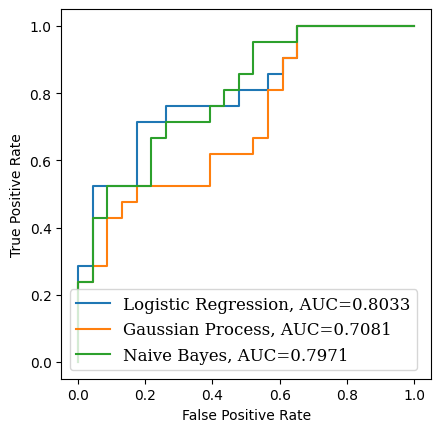

In [ ]:
n_components = 5  # pick some components
for name, clf in zip(names, classifiers):
  clf = make_pipeline(
      XdawnCovariances(n_components),
      TangentSpace(metric="riemann"),   
      clf, #LogisticRegression(),
      )
  cv = KFold(n_splits=10, shuffle=True, random_state=42)
  for train_idx, test_idx in cv.split(X): # 
    preds = np.zeros(len(Y))
    y_train, y_test = Y[train_idx], Y[test_idx]
    clf.fit(X[train_idx], y_train)
    #preds[test_idx] = clf.predict(X[test_idx]) # Binary for accuracy
    preds[test_idx] = clf.predict_proba(X[test_idx])[::,1] # Probabilty for AUC
  fpr, tpr, _ = metrics.roc_curve(Y[test_idx], preds[test_idx])
  auc = round(metrics.roc_auc_score(Y[test_idx], preds[test_idx]), 4)
  plt.plot(fpr,tpr,label=name+", AUC="+str(auc))
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
#plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 12#24
plt.rcParams['ytick.labelsize'] = 12#24
plt.rcParams['legend.fontsize'] = 12#24
#plt.rcParams['axes.titlesize'] = 36. 
plt.rcParams['axes.labelsize'] = 12#24
plt.gca().set_aspect('equal')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

## Subexperiment 1 
Consequently add the most prominent users and keep training the mode.
Join the previous two cells to consequently append the users.
Do not change this code, it is fixed.

[1158.]
1158 ------------ [180, 200] shape (83, 128, 410) balance 44 vs 39
[1158. 1045.]
1158 ------------ [180, 200] shape (245, 128, 410) balance 128 vs 117
[1158. 1045. 7980.]
1158 ------------ [180, 200] shape (488, 128, 410) balance 255 vs 233
[1158. 1045. 7980. 1037.]
1158 ------------ [180, 200] shape (791, 128, 410) balance 410 vs 381
[1158. 1045. 7980. 1037. 6639.]
1158 ------------ [180, 200] shape (1143, 128, 410) balance 587 vs 556
[1158. 1045. 7980. 1037. 6639. 1363.]
1158 ------------ [180, 200] shape (1587, 128, 410) balance 812 vs 775
[1158. 1045. 7980. 1037. 6639. 1363. 7977.]
1158 ------------ [180, 200] shape (2109, 128, 410) balance 1083 vs 1026
[1158. 1045. 7980. 1037. 6639. 1363. 7977. 7974.]
1158 ------------ [180, 200] shape (2711, 128, 410) balance 1394 vs 1317
[1158. 1045. 7980. 1037. 6639. 1363. 7977. 7974. 2038.]
1158 ------------ [180, 200] shape (3380, 128, 410) balance 1739 vs 1641
[1158. 1045. 7980. 1037. 6639. 1363. 7977. 7974. 2038. 1327.]
1158 -------

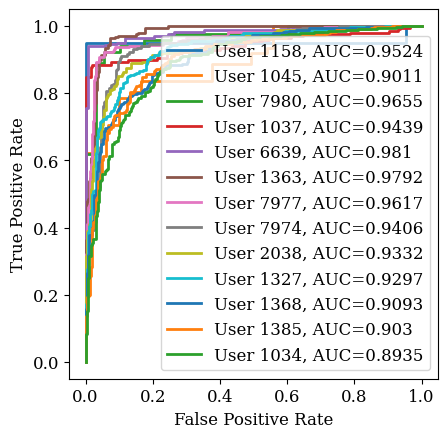

In [ ]:
# Prepare design matrix each time the user joins the dataset
users = np.array([1158,1045,7980,1037,6639,1363,7977,7974,2038,1327,1368,1385,1034])
user = 1158                 
cls = [180, 200]

#userselect = np.array([1158,1045,7980])#,1037,6639,1363])
userselect = np.array([])
idxCls1 = np.array([])
idxCls2 = np.array([])

count = 0
while count < 13:
  userselect = np.append(userselect, users[count])
  
  print(userselect)
  for usersel in userselect:
    idx1 = np.where((dataY[:,EVENT_] == cls[0]) & \
                    (dataY[:,USER_] == usersel) & \
                    (dataY[:,RESP_] > 2))     # Only correct responses
    idx2 = np.where((dataY[:,EVENT_] == cls[1]) & \
                    (dataY[:,USER_] == usersel) & \
                    (dataY[:,RESP_] > 2))     # Only correct responses
    idxCls1 = np.append(idxCls1, idx1, axis=None)
    idxCls2 = np.append(idxCls2, idx2,  axis=None)
  # end for 

  idxCls12 = np.append(idxCls1, idxCls2, axis=None).astype(int)
  #print(idxCls12)
  X12 = np.squeeze(dataX[idxCls12,:,:])
  Y1 = np.zeros(len(idxCls1)) 
  Y2 = np.ones(len(idxCls2)) 
  Y12 = np.append(Y1, Y2)
  print(f'{user} ------------ {cls} shape {X12.shape} balance {np.size(idxCls1)} vs {np.size(idxCls2)}')
  # Run 
  #acc = run_classifier(X1,Y1)
  #print("Classification accuracy: %f " % (acc))  
  X = X12
  Y = Y12

  clf = make_pipeline(
      XdawnCovariances(n_components),
      TangentSpace(metric="riemann"),   
      LogisticRegression(),
      )
  cv = KFold(n_splits=2, shuffle=True, random_state=42)
  for train_idx, test_idx in cv.split(X):
    preds = np.zeros(len(Y))
    y_train, y_test = Y[train_idx], Y[test_idx]
    clf.fit(X[train_idx], y_train)
    #preds[test_idx] = clf.predict(X[test_idx])
    preds[test_idx] = clf.predict_proba(X[test_idx])[::,1]
  fpr, tpr, _ = metrics.roc_curve(Y[test_idx], preds[test_idx])
  auc = round(metrics.roc_auc_score(Y[test_idx], preds[test_idx]), 4)  
  plt.plot(fpr,tpr,label="User "+str(users[count])+", AUC="+str(auc))
  count += 1
# end for
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
#plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 12#24
plt.rcParams['ytick.labelsize'] = 12#24
plt.rcParams['legend.fontsize'] = 12#24
#plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 12#24
plt.gca().set_aspect('equal')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

## Subexperiment 2
Slide window in the timeline from start to the end of the available time-segment and observe change in the accuracy of classification.

32
Next window 32 starts in: 32, of size (444, 128, 32)
Accuracy = 0.6136363636363636, AUC = 0.6708
Next window 32 starts in: 69, of size (444, 128, 32)
Accuracy = 0.75, AUC = 0.7909
Next window 32 starts in: 106, of size (444, 128, 32)
Accuracy = 0.6363636363636364, AUC = 0.6646
Next window 32 starts in: 143, of size (444, 128, 32)
Accuracy = 0.6136363636363636, AUC = 0.6211
Next window 32 starts in: 180, of size (444, 128, 32)
Accuracy = 0.6363636363636364, AUC = 0.6977
Next window 32 starts in: 217, of size (444, 128, 32)
Accuracy = 0.6136363636363636, AUC = 0.6894
Next window 32 starts in: 254, of size (444, 128, 32)
Accuracy = 0.6818181818181818, AUC = 0.7723
Next window 32 starts in: 291, of size (444, 128, 32)
Accuracy = 0.6136363636363636, AUC = 0.6729
Next window 32 starts in: 328, of size (444, 128, 32)
Accuracy = 0.7272727272727273, AUC = 0.7619
Next window 32 starts in: 365, of size (444, 128, 32)
Accuracy = 0.7045454545454546, AUC = 0.7412
Next window 32 starts in: 402, of

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

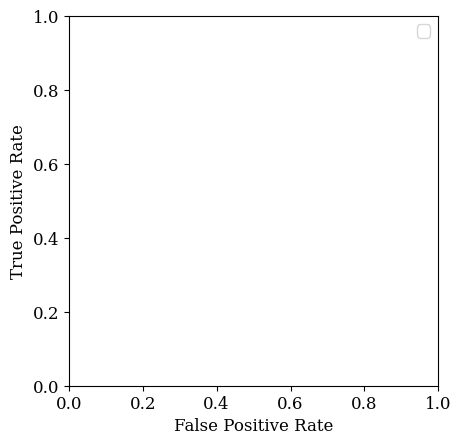

In [ ]:
FREQ_ = 256 # Hertz is the sampling rate here
n_components = 5  # pick some components

clf = make_pipeline(
    XdawnCovariances(n_components),
    TangentSpace(metric="riemann"),   
    LogisticRegression(),
    )
cv = KFold(n_splits=10, shuffle=True, random_state=42)

step = 15 # Control the time of experiment
window = 128 # Half a second
counter = 0
table = np.zeros([0,5])
for win in range(int(window/4), int(1.5 * window), 20):
  print(win)
  for i in range(win, X12.shape[2], int((-win+X12.shape[2])/10)): 
    X = X12[:, :, i-win : i ]
    print(f'Next window {win} starts in: {i}, of size {X.shape}')
    for train_idx, test_idx in cv.split(X):
      preds = np.zeros(len(Y))
      y_train, y_test = Y[train_idx], Y[test_idx]
      clf.fit(X[train_idx], y_train)
    preds[test_idx] = clf.predict_proba(X[test_idx])[::,1]
    fpr, tpr, _ = metrics.roc_curve(Y[test_idx], preds[test_idx])
    auc = round(metrics.roc_auc_score(Y[test_idx], preds[test_idx]), 4)
    #plt.plot(fpr,tpr,label=str(round((i-window)/FREQ_,2)) + ' ms ' + str(round(auc,2)))
    preds = np.zeros(len(Y))
    preds[test_idx] = clf.predict(X[test_idx])
    acc = np.mean(preds == Y)      
    acu = accuracy_score(preds[test_idx], Y[test_idx]) 
    table = np.append(table, [[win, i-win, i, auc, acu]], axis = 0)
    print(f'Accuracy = {acu}, AUC = {auc}')

df = pd.DataFrame(table)
fname = f'Accuracy_sliding_window.xlsx'
df.to_excel(fname, index=False) # Save the DataFrame to an Excel file
files.download(fname)